In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


First, let's start with how to run out model when we're not in the nengo GUI.  Pretty much all you need to do is paste it here!

In addition to that, though, we also need to add Probes (to indicate what data to sae so we can plot it afterwards) and to tell the model to run for a certain amount of time.  That's the code we've added at the end.

In [93]:
import nengo
import nengo_spa as spa
import numpy as np


words = ['CAR', 'BLUE', 'RED']
colors = ['RED', 'BLUE']

D = 16
vocab = spa.Vocabulary(D)
vocab.populate(';'.join(words))
vocab.populate('COLOR; WORD')

stimuli = []
for i in range(10):
    w = np.random.choice(words)
    c = np.random.choice(colors)
    stimuli.append((w,c))

model = spa.Network()
with model:
    
    t_stim = 0.5
    t_isi = 0.5
    def word_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][0]
    def color_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][1]
    stim_w = spa.Transcode(word_func, output_vocab=vocab)
    stim_c = spa.Transcode(color_func, output_vocab=vocab) 
    stim_a = spa.Transcode('COLOR', output_vocab=vocab)
        
        
    wm = spa.State(vocab)
    
    model.config[spa.Bind].neurons_per_dimension = 200
    (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~stim_a >> wm
    
    p_output = nengo.Probe(wm.output, synapse=0.02)  # make sure to filter the data with a synapse when probing neurons
    p_correct = nengo.Probe(stim_c.output)

sim = nengo.Simulator(model)
with sim:
    sim.run(5)    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Now that we've run the model, we can get the data and plot it.

This should be the same data that is being used to make the plots in the nengo GUI

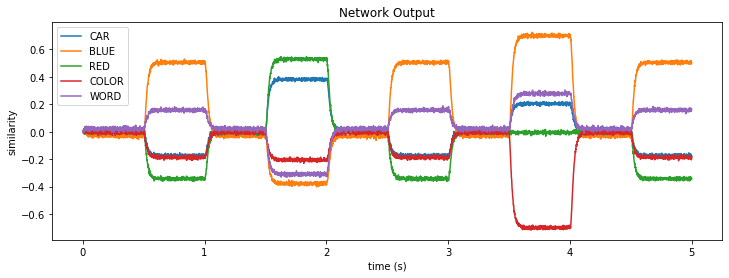

In [102]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_output].dot(vocab.vectors.T))
plt.legend(vocab.keys())
plt.xlabel('time (s)')
plt.ylabel('similarity')
plt.title('Network Output')
plt.show()

But what is the correct answer for these cases?  Let's also plot the correct answer.

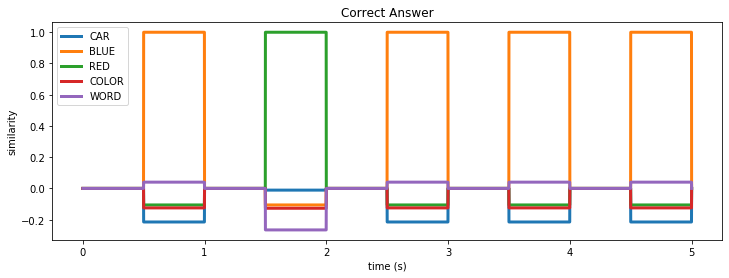

In [101]:
plt.figure(figsize=(12,4))
plt.plot(sim.trange(), sim.data[p_correct].dot(vocab.vectors.T), lw=3)
plt.legend(vocab.keys())
plt.xlabel('time (s)')
plt.ylabel('similarity')
plt.title('Correct Answer')
plt.show()

One measure of accuracy would be the dot product of the actual output and the ideal output.

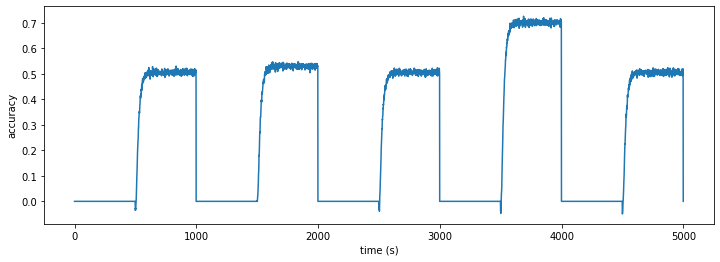

In [104]:
plt.figure(figsize=(12,4))
plt.plot(np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output]))
plt.xlabel('time (s)')
plt.ylabel('accuracy')
plt.show()

This looks pretty good for a simple measure of performance.  But we're also wasting lots of time with those long inter-stimulus intervals and presentation times.  Let's speed that up a bit.

In [105]:
import nengo
import nengo_spa as spa
import numpy as np


words = ['CAR', 'BLUE', 'RED']
colors = ['RED', 'BLUE']

D = 16
vocab = spa.Vocabulary(D)
vocab.populate(';'.join(words))
vocab.populate('COLOR; WORD')

n_stims = 10
stimuli = []
for i in range(n_stims):
    w = np.random.choice(words)
    c = np.random.choice(colors)
    stimuli.append((w,c))

model = spa.Network()
with model:
    
    t_stim = 0.15
    t_isi = 0.05
    def word_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][0]
    def color_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][1]
    stim_w = spa.Transcode(word_func, output_vocab=vocab)
    stim_c = spa.Transcode(color_func, output_vocab=vocab) 
    stim_a = spa.Transcode('COLOR', output_vocab=vocab)
        
        
    wm = spa.State(vocab)
    
    model.config[spa.Bind].neurons_per_dimension = 200
    (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~stim_a >> wm
    
    p_output = nengo.Probe(wm.output, synapse=0.02)
    p_correct = nengo.Probe(stim_c.output)

sim = nengo.Simulator(model)
with sim:
    sim.run(n_stims*(t_isi+t_stim))    


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

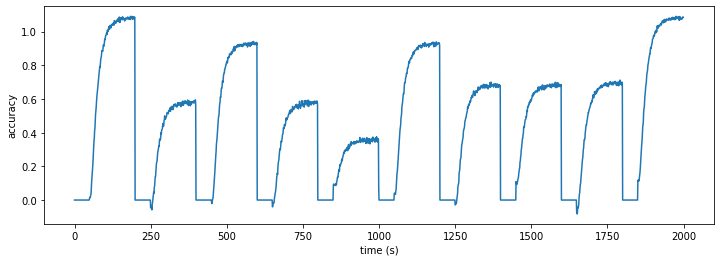

In [107]:
plt.figure(figsize=(12,4))
plt.plot(np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output]))
plt.xlabel('time (s)')
plt.ylabel('accuracy')
plt.show()

Now, what we really want to measure isn't this whole graph, but rather the accuracy values at the end of each presentation.  So let's just grab that.

In [108]:
v = np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output])
steps = int((t_isi+t_stim)/sim.dt)
score = v[steps-2::steps]
print(score)

[1.08416863 0.56807573 0.92410274 0.57424028 0.36385289 0.93159793
 0.67846721 0.68637688 0.69982202 1.0879995 ]


Now we can have a little program that does this experiment and makes this measurement for us.

In [109]:
import nengo
import nengo_spa as spa
import numpy as np


words = ['CAR', 'BLUE', 'RED']
colors = ['RED', 'BLUE']

D = 16
vocab = spa.Vocabulary(D)
vocab.populate(';'.join(words))
vocab.populate('COLOR; WORD')

n_stims = 10
stimuli = []
for i in range(n_stims):
    w = np.random.choice(words)
    c = np.random.choice(colors)
    stimuli.append((w,c))

model = spa.Network()
with model:
    
    t_stim = 0.15
    t_isi = 0.05
    def word_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][0]
    def color_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][1]
    stim_w = spa.Transcode(word_func, output_vocab=vocab)
    stim_c = spa.Transcode(color_func, output_vocab=vocab) 
    stim_a = spa.Transcode('COLOR', output_vocab=vocab)
        
        
    wm = spa.State(vocab)
    
    model.config[spa.Bind].neurons_per_dimension = 200
    (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~stim_a >> wm
    
    p_output = nengo.Probe(wm.output, synapse=0.02)
    p_correct = nengo.Probe(stim_c.output)

sim = nengo.Simulator(model)
with sim:
    sim.run(n_stims*(t_isi+t_stim))    

v = np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output])
steps = int((t_isi+t_stim)/sim.dt)
scores = v[steps-2::steps]
print(scores)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

[0.91239844 0.90791104 0.38804024 0.7257145  0.7381265  0.65947833
 0.66087842 0.65392662 0.90503037 0.72025411]


Now that we have this, we are going to convert this script into the pytry system, which will let you run the model lots of times, vary parameters, and store the data.  

This involves taking the above script and putting it inside a pytry.Trial class.  We also have to identify the various parameters that we want to be able to change, and we have to now refer to those parameters as `p.something` rather than `something`.  Finally, we have to return whatever data we want to store.  Here's what that looks like.

Note: if you do not have pytry installed, then you will need to do `!pip install pytry`

In [110]:
import nengo
import nengo_spa as spa
import numpy as np
import pytry

class AttentionTrial(pytry.Trial):
    def params(self):
        self.param('number of dimensions in semantic pointer', D=16)
        self.param('number of stimuli to test', n_stims=10)
        self.param('inter-stimulus interval', t_isi=0.05)
        self.param('stimulus presentation time', t_stim=0.15)
        
    def evaluate(self, p):
        words = ['CAR', 'BLUE', 'RED']
        colors = ['RED', 'BLUE']

        vocab = spa.Vocabulary(p.D)
        vocab.populate(';'.join(words))
        vocab.populate('COLOR; WORD')

        stimuli = []
        for i in range(p.n_stims):
            w = np.random.choice(words)
            c = np.random.choice(colors)
            stimuli.append((w,c))

        model = spa.Network()
        with model:
            def word_func(t):
                index = int (t / (p.t_stim + p.t_isi))
                t = t % (p.t_stim + p.t_isi)
                if t < p.t_isi:
                    return '0'
                else:
                    return stimuli[index%len(stimuli)][0]
            def color_func(t):
                index = int (t / (p.t_stim + p.t_isi))
                t = t % (p.t_stim + p.t_isi)
                if t < p.t_isi:
                    return '0'
                else:
                    return stimuli[index%len(stimuli)][1]
            stim_w = spa.Transcode(word_func, output_vocab=vocab)
            stim_c = spa.Transcode(color_func, output_vocab=vocab) 
            stim_a = spa.Transcode('COLOR', output_vocab=vocab)

            wm = spa.State(vocab)
            
            (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~stim_a >> wm

            p_output = nengo.Probe(wm.output, synapse=0.02)
            p_correct = nengo.Probe(stim_c.output)

        sim = nengo.Simulator(model)
        with sim:
            sim.run(p.n_stims*(p.t_isi+p.t_stim))    

        v = np.einsum('ij,ij->i',sim.data[p_correct], sim.data[p_output])
        steps = int((p.t_isi+p.t_stim)/sim.dt)
        scores = v[steps-2::steps]
        
        return dict(
            scores=scores,
            mean_score=np.mean(scores)
        )

        

Now that we have this defined, we can run an experiment like this:

In [72]:
AttentionTrial().run()

running AttentionTrial#20200320-124635-2e0018b9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 1
D = 16
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.6471541737466087
scores = array([0.66825325, 0.63269604, 0.66883695, 0.67886915, 0.62363109,
       0.72269448, 0.74197491, 0.38441413, 0.98091976, 0.36925197])


{'mean_score': 0.6471541737466087,
 'scores': array([0.66825325, 0.63269604, 0.66883695, 0.67886915, 0.62363109,
        0.72269448, 0.74197491, 0.38441413, 0.98091976, 0.36925197])}

We can vary a parameter by specifying it in the `run` function.

In [73]:
AttentionTrial().run(D=32)

running AttentionTrial#20200320-124654-0d5691ee


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 1
D = 32
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.8646500345648743
scores = array([0.90600826, 0.81773316, 0.89213481, 0.90957187, 0.82519401,
       0.91105472, 0.91142972, 0.92169715, 0.63784438, 0.91383227])


{'mean_score': 0.8646500345648743,
 'scores': array([0.90600826, 0.81773316, 0.89213481, 0.90957187, 0.82519401,
        0.91105472, 0.91142972, 0.92169715, 0.63784438, 0.91383227])}

That looks like changing `D` made the system better?  But is that change statistically significant?  Let's find out by running multiple trials, each with different random number seeds.  We also specify `data_dir` which indicates what directory to store the resulting data in.

In [75]:
for seed in range(5):
    for D in [16, 32]:
        AttentionTrial().run(seed=seed, D=D, data_dir='vary_dimensions')

running AttentionTrial#20200320-125106-61ef1bce


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 0
D = 16
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.6379965288671677
scores = array([1.00188004, 0.5028319 , 0.68186236, 0.50710718, 0.99207905,
       0.28696831, 0.58216352, 0.77346525, 0.76374092, 0.28786676])
running AttentionTrial#20200320-125113-7429912e


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 0
D = 32
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.7606256111666037
scores = array([0.91601626, 0.62280548, 0.77901825, 0.63369478, 0.90902245,
       0.68073177, 0.75112348, 0.81984241, 0.81365972, 0.6803415 ])
running AttentionTrial#20200320-125123-205a610c


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 1
D = 16
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.862668950420046
scores = array([0.93205065, 0.67303215, 0.93395087, 0.9416795 , 0.68832664,
       0.8886477 , 0.89552787, 1.02399286, 0.61516087, 1.0343204 ])
running AttentionTrial#20200320-125129-5452956f


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 1
D = 32
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.7049100373452296
scores = array([0.52455359, 0.92692044, 0.52369013, 0.53483052, 0.9298418 ,
       0.66731702, 0.64929643, 0.82289551, 0.65526617, 0.81448876])
running AttentionTrial#20200320-125139-0838a365


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 2
D = 16
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.6912009702041036
scores = array([0.75107569, 0.80179254, 0.74592634, 0.75403468, 0.74653159,
       0.74802362, 0.39957683, 0.71504542, 0.84510686, 0.40489613])
running AttentionTrial#20200320-125146-2a6a9984


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 2
D = 32
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.5658254939853301
scores = array([0.69092886, 0.52579008, 0.46919197, 0.48115332, 0.71011426,
       0.48209164, 0.52875642, 0.48877643, 0.7482414 , 0.53321057])
running AttentionTrial#20200320-125156-9b3b22e4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 3
D = 16
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.7736846418327541
scores = array([0.81334712, 0.76032806, 1.05681673, 0.33400898, 0.77680046,
       0.67384388, 0.77914395, 0.67454284, 0.81555424, 1.05246016])
running AttentionTrial#20200320-125203-0a3e3895


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 3
D = 32
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.7036694079059861
scores = array([0.61473355, 0.79584143, 0.79896588, 0.45457825, 0.80794808,
       0.69720859, 0.79682905, 0.68431323, 0.60450394, 0.78177209])
running AttentionTrial#20200320-125213-5bc2a183


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 4
D = 16
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.5798411831508967
scores = array([0.72460159, 0.61324539, 0.73808806, 0.50024418, 0.49524063,
       0.74864034, 0.49086081, 0.48666859, 0.49443883, 0.50638342])
running AttentionTrial#20200320-125219-b29f6835


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

seed = 4
D = 32
n_stims = 10
t_isi = 0.05
t_stim = 0.15
mean_score = 0.7803069261240776
scores = array([0.84632204, 0.42035029, 0.66228445, 0.89912974, 0.83880359,
       0.66493064, 0.84387903, 0.85070673, 0.89523623, 0.88142652])


Now we can read all that data in

In [78]:
data = pytry.read('vary_dimensions')
df = pandas.DataFrame(data)
df

,D,mean_score,n_stims,scores,seed,t_isi,t_stim
0,16,0.637997,10,"[1.00188004, 0.5028319, 0.68186236, 0.50710718...",0,0.05,0.15
1,32,0.760626,10,"[0.91601626, 0.62280548, 0.77901825, 0.6336947...",0,0.05,0.15
2,16,0.862669,10,"[0.93205065, 0.67303215, 0.93395087, 0.9416795...",1,0.05,0.15
3,32,0.704910,10,"[0.52455359, 0.92692044, 0.52369013, 0.5348305...",1,0.05,0.15
4,16,0.691201,10,"[0.75107569, 0.80179254, 0.74592634, 0.7540346...",2,0.05,0.15
5,32,0.565825,10,"[0.69092886, 0.52579008, 0.46919197, 0.4811533...",2,0.05,0.15
6,16,0.773685,10,"[0.81334712, 0.76032806, 1.05681673, 0.3340089...",3,0.05,0.15
7,32,0.703669,10,"[0.61473355, 0.79584143, 0.79896588, 0.4545782...",3,0.05,0.15
8,16,0.579841,10,"[0.72460159, 0.61324539, 0.73808806, 0.5002441...",4,0.05,0.15
9,32,0.780307,10,"[0.84632204, 0.42035029, 0.66228445, 0.8991297...",4,0.05,0.15


And we can plot it using `seaborn`.  That automatically gives 95% bootstrap confidence intervals.

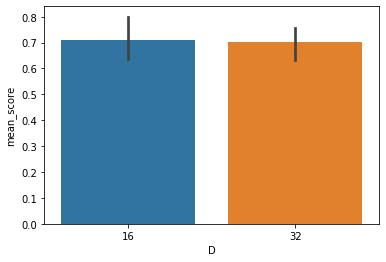

In [111]:
seaborn.barplot('D', 'mean_score', data=df)

Hmm, it doesn't look like the mean changed.  But maybe the standard deviation has?  Let's load the data in again, but this time also compute the standard deviation.

In [112]:
data = pytry.read('vary_dimensions')
data2 = []
for d in data:
    d['sd_score'] = np.std(d['scores'])
    data2.append(d)
df = pandas.DataFrame(data2)

In [113]:
df

,D,mean_score,n_stims,scores,sd_score,seed,t_isi,t_stim
0,16,0.637997,10,"[1.00188004, 0.5028319, 0.68186236, 0.50710718...",0.240459,0,0.05,0.15
1,32,0.760626,10,"[0.91601626, 0.62280548, 0.77901825, 0.6336947...",0.100424,0,0.05,0.15
2,16,0.862669,10,"[0.93205065, 0.67303215, 0.93395087, 0.9416795...",0.141774,1,0.05,0.15
3,32,0.704910,10,"[0.52455359, 0.92692044, 0.52369013, 0.5348305...",0.150691,1,0.05,0.15
4,16,0.691201,10,"[0.75107569, 0.80179254, 0.74592634, 0.7540346...",0.148432,2,0.05,0.15
5,32,0.565825,10,"[0.69092886, 0.52579008, 0.46919197, 0.4811533...",0.101608,2,0.05,0.15
6,16,0.773685,10,"[0.81334712, 0.76032806, 1.05681673, 0.3340089...",0.193529,3,0.05,0.15
7,32,0.703669,10,"[0.61473355, 0.79584143, 0.79896588, 0.4545782...",0.111102,3,0.05,0.15
8,16,0.579841,10,"[0.72460159, 0.61324539, 0.73808806, 0.5002441...",0.108806,4,0.05,0.15
9,32,0.780307,10,"[0.84632204, 0.42035029, 0.66228445, 0.8991297...",0.145307,4,0.05,0.15


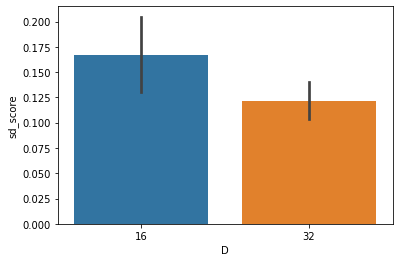

In [114]:
seaborn.barplot('D', 'sd_score', data=df)

It seems like changing the number of dimensions is improving the variability of performance, but not the mean.